# Sentinel-1 GRD Orthorectified, Terrain Corrected Gamma0 Time Series 

__Sentinel-Hub Sentinel-1 GRD data processing chain (taken from website):__
1. Original or multilooked source chosen (depending on the resolution level; multilooking is done in ground range. Also see.)
2. Calibration to the chosen backscatter coefficient and thermal noise removal applied.
3. (Optional) Radiometric terrain correction using [flattening gamma](https://www.geo.uzh.ch/microsite/rsl-documents/research/publications/peer-reviewed-articles/201108-TGRS-Small-tcGamma-3809999360/201108-TGRS-Small-tcGamma.pdf) is performed (Mapzen or Copernicus DEM).
4. (Optional) Orthorectification using Range-Doppler terrain correction is performed (Mapzen or Copernicus DEM).

__Notes:__
* Orbit files bundled in the products are utilised for geolocation.
* Areas of border noise are not displayed by Sentinel Hub.
* No speckle filtering is applied at any stage. 
* Radiometric terrain correction can only be performed if orthorectification is enabled. 
* The DEM, if used, is resampled using bilinear interpolation, and the same DEM is used for both radiometric terrain correction and orthorectification, provided both are enabled.

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'process'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process'

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-1' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process\\cfg\\sentinel-1'

### _Load configuration file from repository cfg sub-directory_ 

In [4]:
# print contents of configuration file
cfg_file = os.path.join( cfg_path, 's1-timeseries-ard.yml' )
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: ["VV", "VH", "localIncidenceAngle", "scatteringArea", "shadowMask" ],
                        output: [{ // this is now an array since there are multiple output objects
                          id: "vv",
                          bands: 1,
                          sampleType: "FLOAT32"
                        }, {
                          id: "vh",
                          bands: 1,
                          sampleType: "FLOAT32"
                        }, {
                          id: "inc_angle",
                          bands: 1,
                          sampleType: "FLOAT32"
                        }, {
                          id: "scatter_area",
                          bands: 1,
                          sampleType: "UINT8"
                        }, {
                          id: "shadow_mask",
                         

In [5]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )
config

Munch({'request': Munch({'evalscript': '//VERSION=3\nfunction setup() {\n    return {\n        input: ["VV", "VH", "localIncidenceAngle", "scatteringArea", "shadowMask" ],\n        output: [{ // this is now an array since there are multiple output objects\n          id: "vv",\n          bands: 1,\n          sampleType: "FLOAT32"\n        }, {\n          id: "vh",\n          bands: 1,\n          sampleType: "FLOAT32"\n        }, {\n          id: "inc_angle",\n          bands: 1,\n          sampleType: "FLOAT32"\n        }, {\n          id: "scatter_area",\n          bands: 1,\n          sampleType: "UINT8"\n        }, {\n          id: "shadow_mask",\n          bands: 1,\n          sampleType: "UINT8"\n        } ]\n    }\n}\nfunction evaluatePixel(samples) {\n    return {\n        vv: [ toDb(samples.VV) ],\n        vh: [ toDb(samples.VH) ],\n        inc_angle: [ samples.localIncidenceAngle ],\n        scatter_area: [ samples.scatteringArea ],\n        shadow_mask: [ samples.shadowMask ]\

### _Define topographically fun area of interest in Austrian Alps_

In [6]:
# austrian alps
coords = 11.132122,47.417681,11.462311,47.631712
resolution = 10

In [7]:
# create instance of shclient class
from processapi import Client
client = Client( config )

In [8]:
# get utm bbox
bbox = client.getBoundingBox( coords )
print ( bbox, bbox.crs.value )

660825.1702357616,5253784.965185334,684975.6315037415,5278305.353664223 32632


### _Use Sentinel Hub catalog API to search for S1 datasets acquired on 1st January 2021_

In [9]:
# set timeframe for new years day 2021
from datetime import datetime
timeframe = { 'start' : datetime( 2021, 1, 1, 0, 0, 0 ), 'end' : datetime( 2021, 1, 1, 23, 59, 59 ) }

In [10]:
# check out catalog result
client.getDatasetTimeStamps( config.request.inputs[ 0 ], bbox, timeframe )

[datetime.datetime(2021, 1, 1, 5, 26, 44, tzinfo=tzutc())]

### _Download scenes from Sentinel Hub collocated with bounding box and timeframe_

In [11]:
# dump request to validate options
request = client.getRequest( bbox, timeframe, resolution )
request.payload

{'input': {'bounds': {'properties': {'crs': 'http://www.opengis.net/def/crs/EPSG/0/32632'},
   'bbox': [660825.1702357616,
    5253784.965185334,
    684975.6315037415,
    5278305.353664223]},
  'data': [InputDataDict({'type': 'sentinel-1-grd', 'dataFilter': {'timeRange': {'from': '2021-01-01T00:00:00Z', 'to': '2021-01-01T23:59:59Z'}, 'mosaickingOrder': 'mostRecent'}, 'processing': {'orthorectify': True, 'backCoeff': 'GAMMA0_TERRAIN'}}, service_url=https://services.sentinel-hub.com)]},
 'evalscript': '//VERSION=3\nfunction setup() {\n    return {\n        input: ["VV", "VH", "localIncidenceAngle", "scatteringArea", "shadowMask" ],\n        output: [{ // this is now an array since there are multiple output objects\n          id: "vv",\n          bands: 1,\n          sampleType: "FLOAT32"\n        }, {\n          id: "vh",\n          bands: 1,\n          sampleType: "FLOAT32"\n        }, {\n          id: "inc_angle",\n          bands: 1,\n          sampleType: "FLOAT32"\n        }, {\n 

In [12]:
# get gamma0 ellipsoid + ancillary imagery
response = client.getTimeSeries ( bbox, timeframe, resolution )
response._df

vv.tif  \
0  [[-30.348446, -26.637491, -25.426828, -27.8912...   

                                              vh.tif  \
0  [[-44.588467, -34.981335, -34.457085, -38.4162...   

                                       inc_angle.tif  \
0  [[37.72674, 35.454693, 34.898113, 37.724876, 3...   

                                    scatter_area.tif  \
0  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   

                                     shadow_mask.tif                      time  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,... 2021-01-01 05:26:44+00:00

### _Display orthorectified, terrain corrected Gamma0 VV image_ 

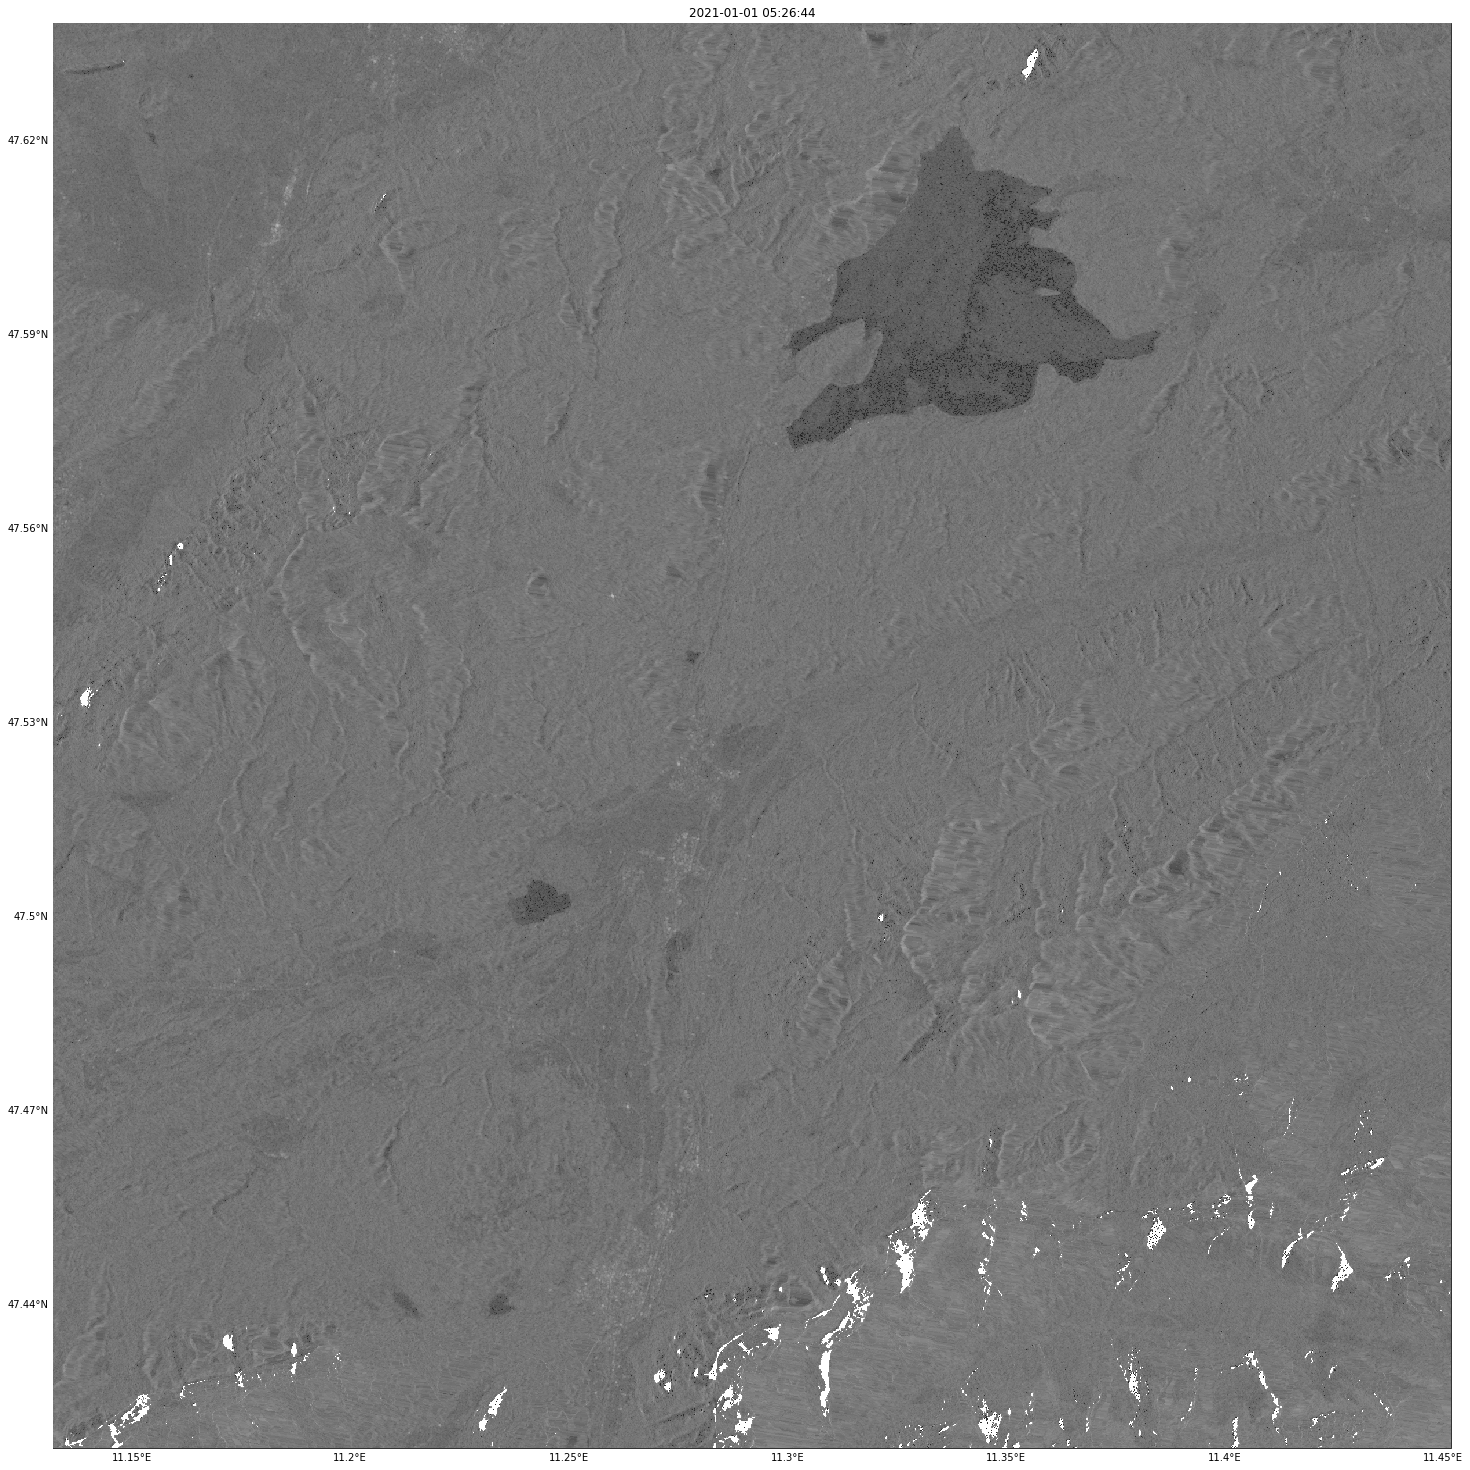

In [13]:
response.plotImages( 'vv.tif', alpha={ 'data' : 1.0, 'grid' : 0.0 }, cmap='gray' )

### _Display orthorectified, terrain corrected Gamma0 VH image_ 

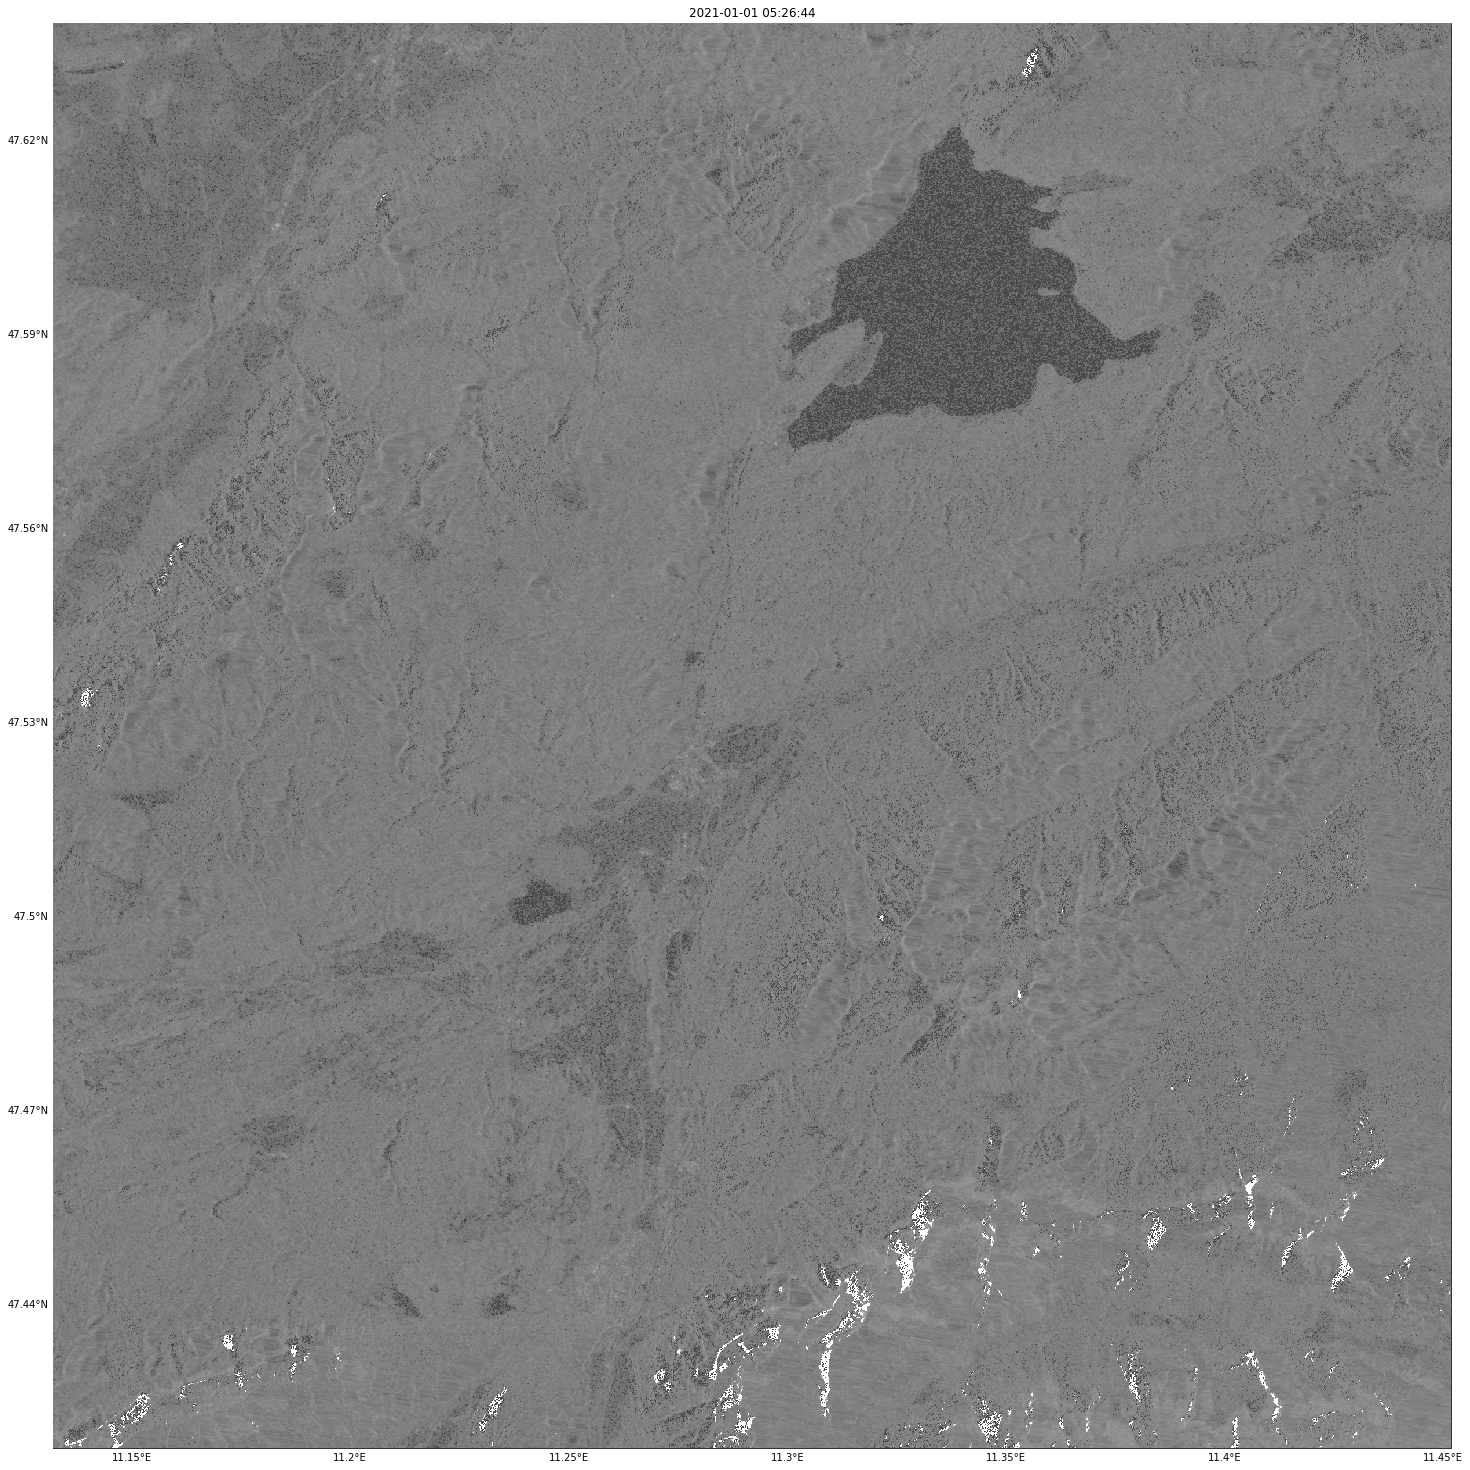

In [14]:
response.plotImages( 'vh.tif', alpha={ 'data' : 1.0, 'grid' : 0.0 }, cmap='gray' )

### _Display shadow mask computed for radiometric terrain correction_

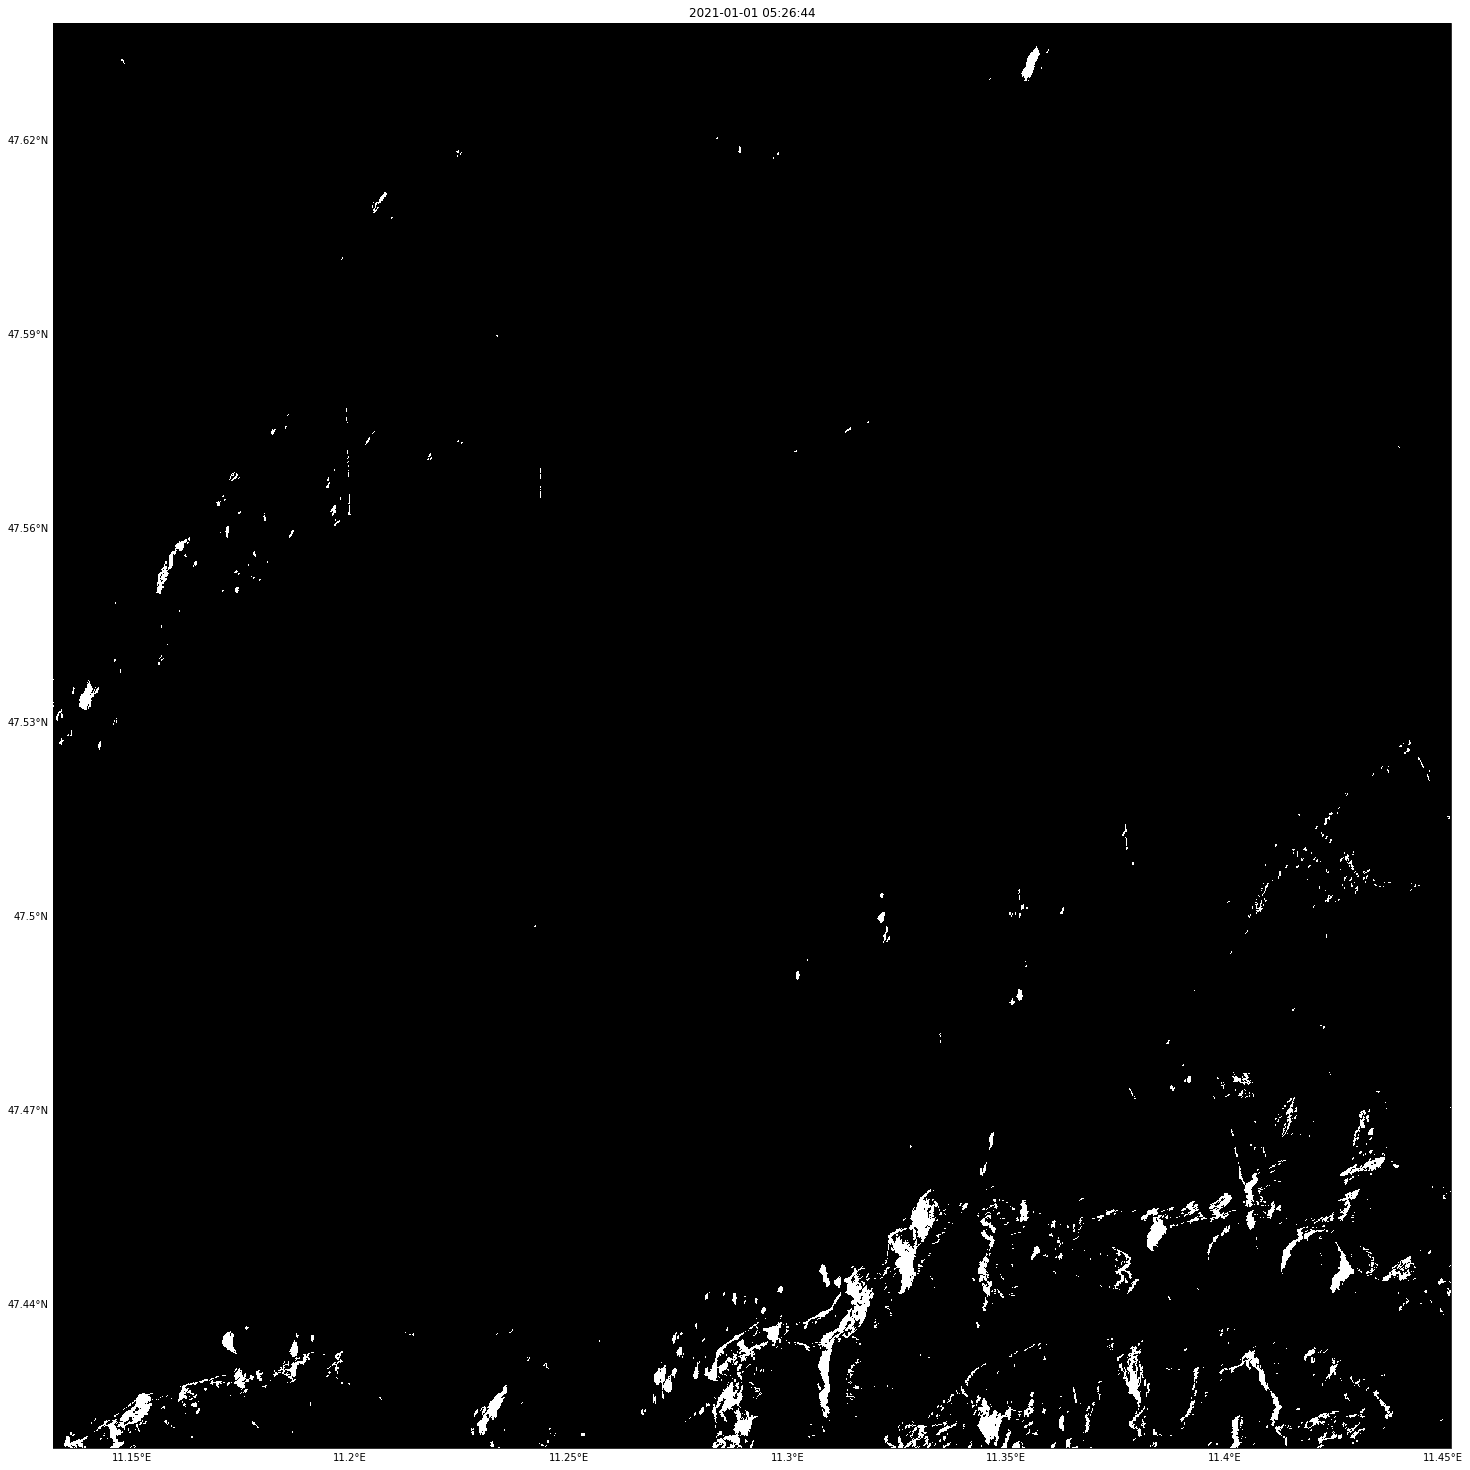

In [15]:
response.plotImages( 'shadow_mask.tif', alpha={ 'data' : 1.0, 'grid' : 0.0 }, cmap='gray' )

### _Transpose georeferenced rasters into Xarray Dataset for spatiotemporal analysis_

In [16]:
ds = response.convertToDataset()
ds

<xarray.Dataset>
Dimensions:           (x: 2415, y: 2452, time: 1)
Coordinates:
    east              (x) float64 6.608e+05 6.608e+05 ... 6.85e+05 6.85e+05
    north             (y) float64 5.278e+06 5.278e+06 ... 5.254e+06 5.254e+06
  * time              (time) datetime64[ns] 2021-01-01T05:26:44
Dimensions without coordinates: x, y
Data variables:
    vv.tif            (x, y, time) float32 -30.35 -39.27 -37.92 ... -10.7 -10.7
    vh.tif            (x, y, time) float32 -44.59 -46.65 ... -26.69 -26.69
    inc_angle.tif     (x, y, time) float32 37.73 37.73 37.73 ... 26.5 22.85
    scatter_area.tif  (x, y, time) uint8 1 1 1 1 1 1 1 1 1 ... 9 9 9 9 10 9 7 7
    shadow_mask.tif   (x, y, time) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0